# CVD prediction using Deep Learning

In this project, we use the [Cardiovascular Disease dataset](https://www.kaggle.com/sulianova/cardiovascular-disease-dataset) from kaggle. 

Based on some health conditions of an individual our model will predict whether someone will have a cardiovascular disease or not.

Features:

* Age | Objective Feature | age | int (days)
* Height | Objective Feature | height | int (cm) |
* Weight | Objective Feature | weight | float (kg) |
* Gender | Objective Feature | gender | categorical code |
* Systolic blood pressure | Examination Feature | ap_hi | int |
* Diastolic blood pressure | Examination Feature | ap_lo | int |
* Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
* Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
* Smoking | Subjective Feature | smoke | binary |
* Alcohol intake | Subjective Feature | alco | binary |
* Physical activity | Subjective Feature | active | binary |
* Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

In [1]:
#importing basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

raw_data = pd.read_csv('../input/cardiovascular-disease-dataset/cardio_train.csv',sep=';')
# Check the data
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [2]:
raw_data.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [3]:
print(f"Missing values are present: {raw_data.isnull().sum().any()}")

Missing values are present: False


* There is no missing value in the data.
* We will drop column 'id' as it is irrelevant to target variable.
* Transform age column into years instead of days.
* Gender feature should not be categorized into 1 and 2 because 2 is always numerically bigger than 1, the model would take into account that and give a bigger ratio to one gender for having a disease. So, I will make that binary.
* I will check and drop duplicates.

In [4]:
raw_data.drop('id',axis=1,inplace=True)
raw_data.age = (raw_data.age / 365).round().astype('int')
raw_data.gender = raw_data.gender.replace(2,0)

In [5]:
raw_data.duplicated().sum()

3816

In [6]:
raw_data.drop_duplicates(inplace=True)

# Data Preprocessing and Data Analysis

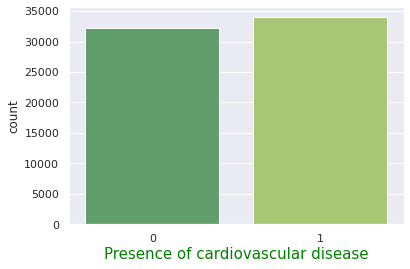

In [7]:
sns.set_style('darkgrid')
sns.countplot(raw_data.cardio,palette='summer')
plt.xlabel('Presence of cardiovascular disease',fontdict={'fontsize': 15,'color':'Green'},labelpad=3);

So, data is almost balanced. Let's see which gender has more cases of disease. As in this data there was no knowledge of which gender is denoted by which number, I will use simple fact that women's average height is less than that of men.

In [8]:
a = raw_data[raw_data["gender"]==0]["height"].mean()
b = raw_data[raw_data["gender"]==1]["height"].mean()
if a > b:
    gender = "male"
    gender1 = "female"
else:
    gender = "female"
    gender1 = "male"
print("Gender:0 is "+ gender +" & Gender:1 is " + gender1)

Gender:0 is male & Gender:1 is female


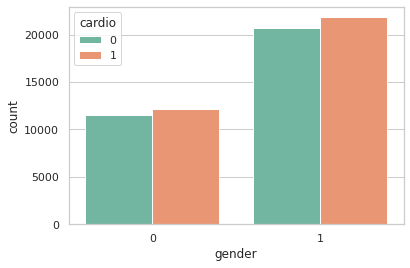

In [9]:
sns.set_style('whitegrid')
sns.countplot(raw_data.gender,hue=raw_data.cardio, palette="Set2");

Age is measured in days, height is in centimeters. Let's look at the numerical variables and how are they spread among target class. For example, at what age does the number of people with CVD exceed the number of people without CVD?

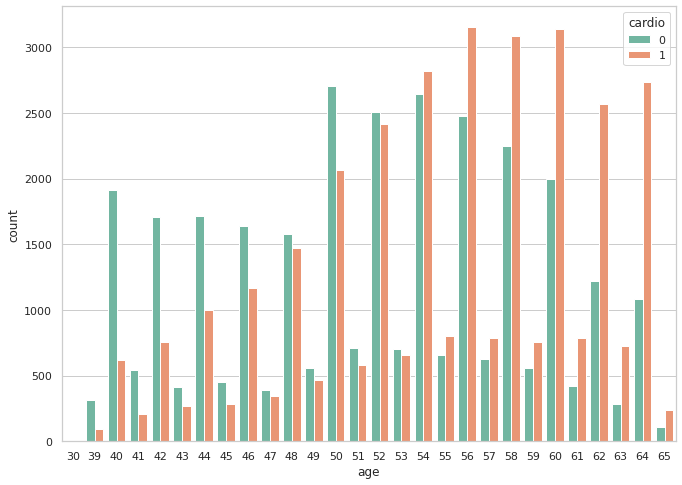

In [10]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
sns.countplot(x='age', hue='cardio', data = raw_data, palette="Set2");

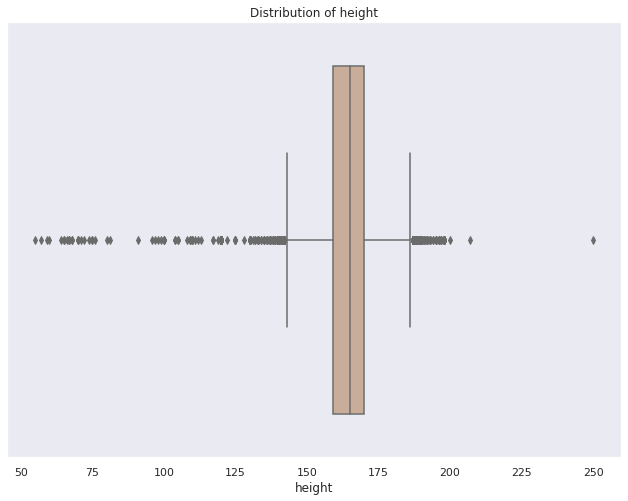

In [11]:
sns.set_style('dark')
sns.boxplot(raw_data.height,palette='pink')
plt.title('Distribution of height');

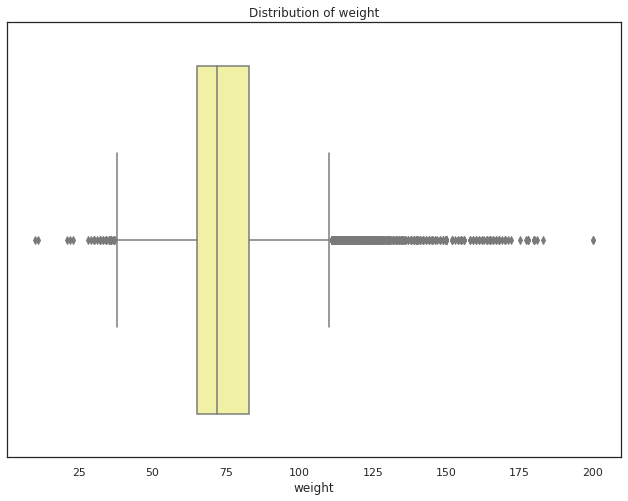

In [12]:
sns.set_style('white')
sns.boxplot(raw_data.weight,palette='terrain')
plt.title('Distribution of weight');

I will remove extremely rare cases of height and weight. As data is quite big, there will be no prblem while modelling.

In [13]:
raw_data = raw_data[(raw_data['height']<250) & (raw_data['weight']>20.0)]

There are many outliers in height and weight features. I combine both of these into a new feature called bmi.

$$ BMI = \frac{Weight(kg)}{Height(m)^{2}} $$

In [14]:
raw_data["bmi"] = (raw_data["weight"]/ (raw_data["height"]/100)**2).round(1)

In [15]:
raw_data[raw_data['bmi']<10]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
26806,64,1,157,23.0,110,80,1,1,0,0,1,0,9.3
29488,56,0,177,22.0,120,80,1,1,1,1,1,0,7.0
60188,60,1,162,21.0,120,80,2,1,0,0,1,1,8.0
60699,52,1,171,29.0,110,70,2,1,0,0,1,1,9.9


In [16]:
raw_data[raw_data['bmi']>100].sort_values(by='weight',ascending=False).head(5)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
27384,42,1,80,178.0,140,90,3,3,0,0,1,1,278.1
8171,48,0,97,170.0,160,100,1,1,1,0,1,1,180.7
12770,54,1,75,168.0,120,80,1,1,1,0,1,1,298.7
15366,48,1,125,167.0,180,90,1,2,0,0,1,1,106.9
20028,54,1,112,167.0,180,120,1,1,0,1,1,0,133.1


Further, we will remove extremely underweight and obese people because such cases seems impossible. Maybe it was a fake observation or typing mistake. Also, health conditions of dwarf and abnormally tall people are totally different so we do not want to include them.

In [17]:
data= raw_data[(raw_data['bmi']>10) & (raw_data['bmi']<100)].copy()

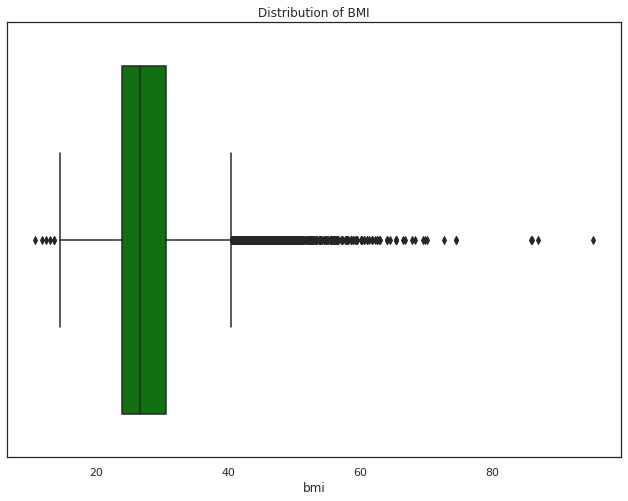

In [18]:
sns.boxplot(data.bmi,color='Green')
plt.title('Distribution of BMI');

In [19]:
data.drop(['weight','height'],axis=1,inplace=True)

Observations have been recorded mostly for people with age between 40 and 65


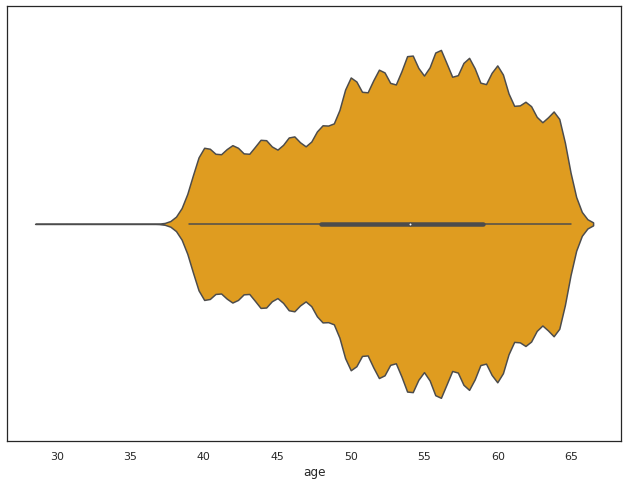

In [20]:
sns.violinplot(data.age,color='orange')
print("Observations have been recorded mostly for people with age between 40 and 65");

Now, I will remove outliers and abrupt blood pressure values.

In [21]:
(data['ap_lo']>360).sum()

952

In [22]:
(data['ap_hi']>360).sum()

39

In [23]:
data= data[(data['ap_lo']<360) & (data['ap_hi']<360)].copy()
data= data[(data['ap_lo']>20) & (data['ap_hi']>20)].copy()
data= data[data['ap_hi']>data['ap_lo']]

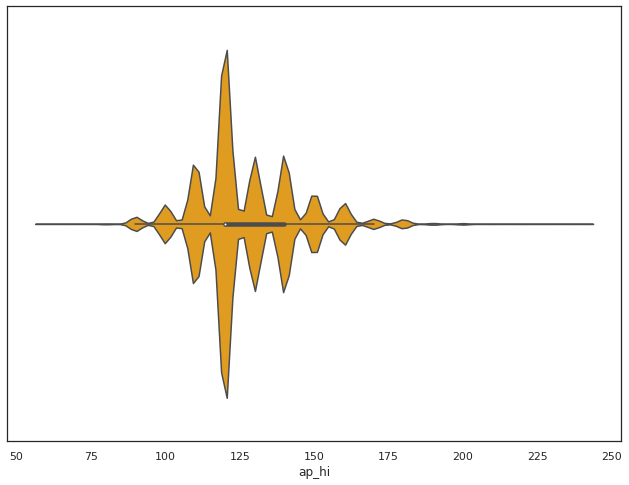

In [24]:
sns.violinplot(data.ap_hi,color='orange');

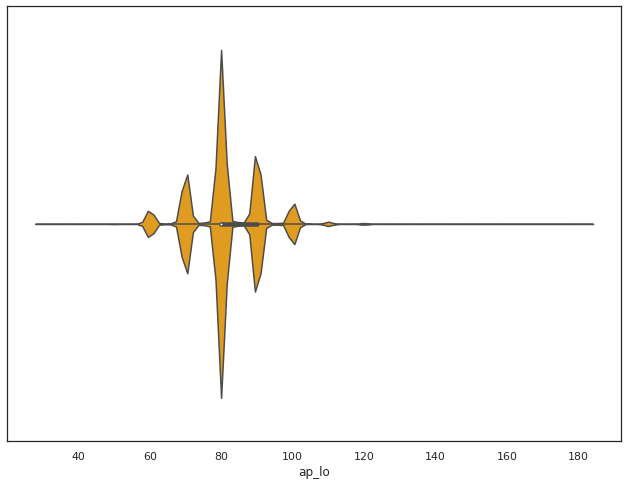

In [25]:
sns.violinplot(data.ap_lo,color='orange');

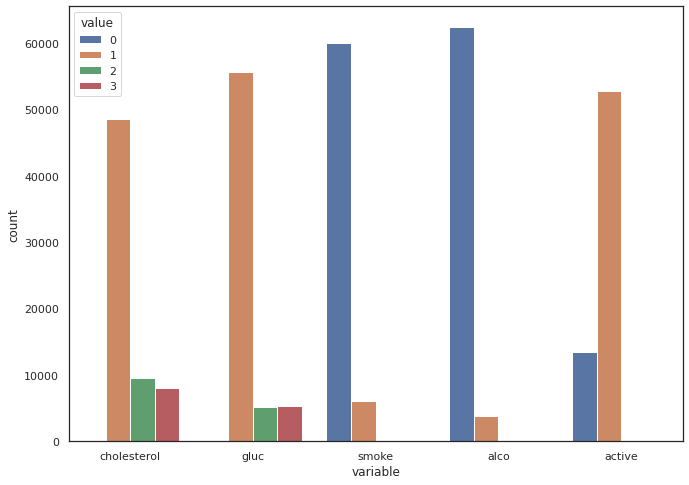

In [26]:
df_categorical = raw_data.loc[:,['cholesterol','gluc', 'smoke', 'alco', 'active']]
sns.countplot(x="variable", hue="value",data= pd.melt(df_categorical));

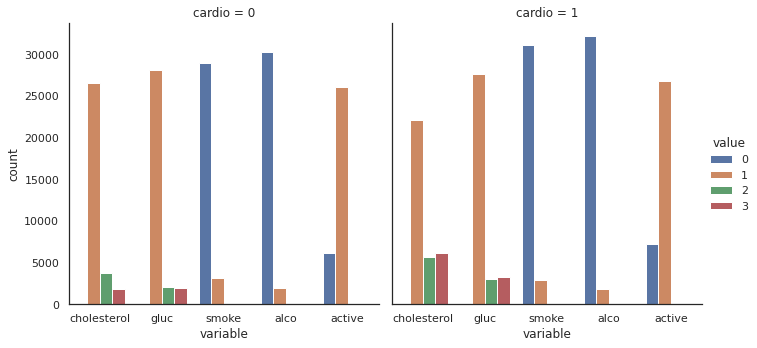

In [27]:
df_long = pd.melt(raw_data, id_vars=['cardio'], value_vars=['cholesterol','gluc', 'smoke', 'alco', 'active'])
sns.catplot(x="variable", hue="value", col="cardio",
                data=df_long, kind="count");

It can be clearly seen that patients with CVD have higher cholesterol and blood glucose level. And, generally speaking less active.

In [28]:
raw_data.gender.value_counts()

1    42540
0    23641
Name: gender, dtype: int64

Who more often report consuming alcohol - men or women?

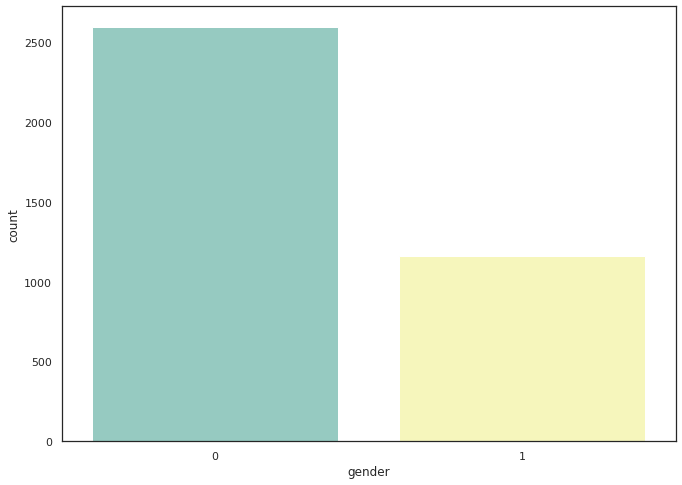

In [29]:
df_alco = raw_data.groupby('gender')['alco'].sum()
raw_data_2 = raw_data[(raw_data['alco']==1)].copy()
sns.countplot(raw_data_2.gender, palette="Set3");

In [30]:
pd.crosstab(raw_data['cardio'],raw_data['gender'],normalize=True)

gender,0,1
cardio,,
0,0.173433,0.312975
1,0.183784,0.329808


In [31]:
#creating dummy variables for categorical column
data['cholesterol']=data['cholesterol'].map({ 1: 'normal', 2: 'above normal', 3: 'well above normal'})
data['gluc']=data['gluc'].map({ 1: 'normal', 2: 'above normal', 3: 'well above normal'})
dummies = pd.get_dummies(data[['cholesterol','gluc']],drop_first=True)
final_data = pd.concat([data,dummies],axis=1)
final_data.drop(['cholesterol','gluc'],axis=1,inplace=True)
final_data.head()

,age,gender,ap_hi,ap_lo,smoke,alco,active,cardio,bmi,cholesterol_normal,cholesterol_well above normal,gluc_normal,gluc_well above normal
0,50,0,110,80,0,0,1,0,22.0,1,0,1,0
1,55,1,140,90,0,0,1,1,34.9,0,1,1,0
2,52,1,130,70,0,0,0,1,23.5,0,1,1,0
3,48,0,150,100,0,0,1,1,28.7,1,0,1,0
4,48,1,100,60,0,0,0,0,23.0,1,0,1,0


In [32]:
#plotting using plotly
import cufflinks as cf
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()

print('Correlation of features with target variable')
final_data.corr()['cardio'].sort_values()[:-1].iplot(kind='barh');

Correlation of features with target variable


### Splitting and Standardizing data

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(final_data.drop('cardio',axis=1),final_data.cardio,test_size=0.30)

to_be_scaled_feat = ['age', 'ap_hi', 'ap_lo','bmi']
other_feat = ['gender', 'cholesterol_normal', 'cholesterol_well above normal',
       'gluc_normal', 'gluc_well above normal', 'smoke', 'alco', 'active']
scaler=StandardScaler()
scaler.fit(X_train[to_be_scaled_feat])
X_train[to_be_scaled_feat] = scaler.transform(X_train[to_be_scaled_feat])
X_test[to_be_scaled_feat] = scaler.transform(X_test[to_be_scaled_feat])

In [34]:
import joblib

joblib.dump(scaler, 'scaler.h5')

['scaler.h5']

In [35]:
joblib.load('scaler.h5')

StandardScaler()

### Out of the box classifiers

In [36]:
# importing classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report

In [37]:
classifiers = {
    'Logistic Regression' : LogisticRegression(),
    'Decision Tree' : DecisionTreeClassifier(),
    'Random Forest' : RandomForestClassifier(),
    'Support Vector Machines' : SVC(),
    'K-nearest Neighbors' : KNeighborsClassifier(),
    'XGBoost' : XGBClassifier()
}
results=pd.DataFrame(columns=['Accuracy in %','F1-score','Recall', 'Precision'])
for method,func in classifiers.items():
    func.fit(X_train,y_train)
    pred = func.predict(X_test)
    results.loc[method]= [100*np.round(accuracy_score(y_test,pred),decimals=4),
                         round(f1_score(y_test,pred),2), round(recall_score(y_test,pred),2),
                         round(precision_score(y_test,pred),2),]
results

,Accuracy in %,F1-score,Recall,Precision
Logistic Regression,72.83,0.72,0.69,0.76
Decision Tree,62.52,0.62,0.60,0.65
Random Forest,67.41,0.68,0.68,0.68
Support Vector Machines,73.44,0.73,0.69,0.77
K-nearest Neighbors,68.84,0.69,0.69,0.70
XGBoost,73.16,0.73,0.70,0.76


# Deep Neural Networks

In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report


In [39]:
#splitting further into validation set
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.20)

model = Sequential()
model.add(Dense(12,activation='relu'))
model.add(Dense(50,activation='relu',kernel_initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1),
    bias_initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1)))
model.add(Dropout(0.2))
model.add(Dense(50,activation='relu',kernel_initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1),
    bias_initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1)))
model.add(Dropout(0.2))
model.add(Dense(50,activation='relu',kernel_initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1),
    bias_initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1)))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history = model.fit(x=X_train.values,y=y_train.values,
          validation_data=(X_val,y_val.values),
          batch_size=100,epochs=100,callbacks=[early_stop])

2022-06-05 09:13:32.909001: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 09:13:32.915068: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 09:13:32.916142: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 09:13:32.917561: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/100
364/364 [==============================] - 4s 5ms/step - loss: 0.5814 - accuracy: 0.7092 - val_loss: 0.5564 - val_accuracy: 0.7247
Epoch 2/100
364/364 [==============================] - 2s 4ms/step - loss: 0.5611 - accuracy: 0.7239 - val_loss: 0.5520 - val_accuracy: 0.7258
Epoch 3/100
364/364 [==============================] - 2s 5ms/step - loss: 0.5575 - accuracy: 0.7251 - val_loss: 0.5507 - val_accuracy: 0.7266
Epoch 4/100
364/364 [==============================] - 2s 5ms/step - loss: 0.5555 - accuracy: 0.7269 - val_loss: 0.5481 - val_accuracy: 0.7274
Epoch 5/100
364/364 [==============================] - 2s 4ms/step - loss: 0.5558 - accuracy: 0.7277 - val_loss: 0.5470 - val_accuracy: 0.7281
Epoch 6/100
364/364 [==============================] - 2s 5ms/step - loss: 0.5540 - accuracy: 0.7280 - val_loss: 0.5468 - val_accuracy: 0.7240
Epoch 7/100
364/364 [==============================] - 2s 4ms/step - loss: 0.5534 - accuracy: 0.7276 - val_loss: 0.5481 - val_accuracy: 0.7256

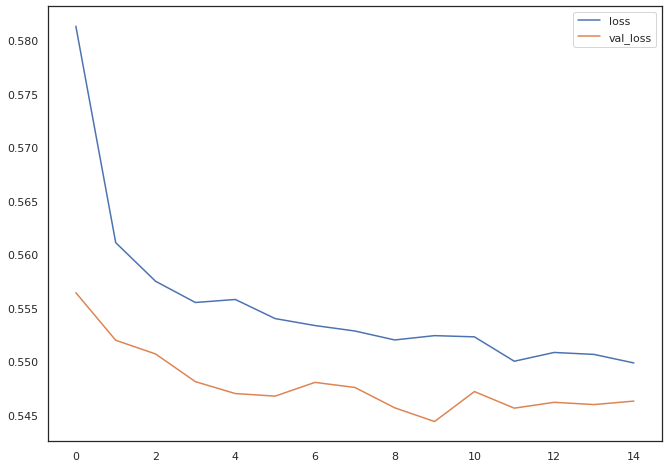

In [40]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot();

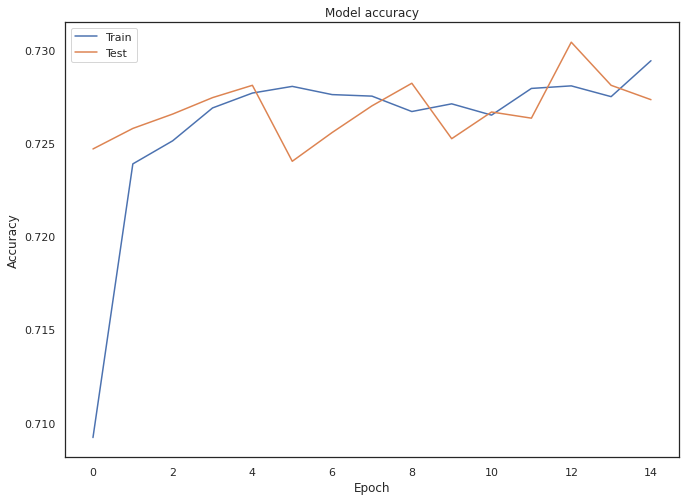

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [42]:
dnn_pred = model.predict(X_test)
classes_x = np.rint(dnn_pred).astype("int32")
print(classification_report(y_test, classes_x))

              precision    recall  f1-score   support

           0       0.72      0.74      0.73      9481
           1       0.75      0.72      0.74      9968

    accuracy                           0.73     19449
   macro avg       0.73      0.73      0.73     19449
weighted avg       0.73      0.73      0.73     19449



In [43]:
from keras.models import load_model

model.save('cdv_dnn_model.h5')

In [44]:
model = load_model('cdv_dnn_model.h5')

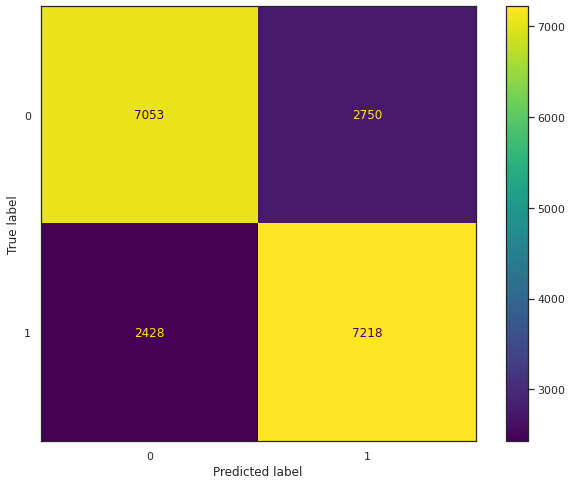

In [45]:
from sklearn.metrics import confusion_matrix, plot_roc_curve, accuracy_score, ConfusionMatrixDisplay
cm = confusion_matrix(classes_x, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()
plt.show()

# Results and comparison

In [46]:
import numpy as np
results.loc['Deep Neural Network']= [100*np.round(accuracy_score(y_test,classes_x),decimals=4),
                         round(f1_score(y_test,classes_x),2), round(recall_score(y_test,pred),2),
                         round(precision_score(y_test,pred),2),]
results.sort_values(by='Accuracy in %',ascending=False).style.highlight_max(color = 'lightgreen')

,Accuracy in %,F1-score,Recall,Precision
Support Vector Machines,73.440000,0.730000,0.690000,0.770000
Deep Neural Network,73.380000,0.740000,0.700000,0.760000
XGBoost,73.160000,0.730000,0.700000,0.760000
Logistic Regression,72.830000,0.720000,0.690000,0.760000
K-nearest Neighbors,68.840000,0.690000,0.690000,0.700000
Random Forest,67.410000,0.680000,0.680000,0.680000
Decision Tree,62.520000,0.620000,0.600000,0.650000


## Single input prediction

#### We scale the given input based on the train set ,with the already used StandardScaler object.

In [47]:
input = [[23,0,130,75,1,0,1,21,1,0,1,0]]
input_df = pd.DataFrame(input, columns=X_train.columns)
input_df[to_be_scaled_feat] = scaler.transform(input_df[to_be_scaled_feat])
input_df

,age,gender,ap_hi,ap_lo,smoke,alco,active,bmi,cholesterol_normal,cholesterol_well above normal,gluc_normal,gluc_well above normal
0,-4.466816,0,0.17479,-0.659057,1,0,1,-1.230381,1,0,1,0


In [48]:
X_train.columns

Index(['age', 'gender', 'ap_hi', 'ap_lo', 'smoke', 'alco', 'active', 'bmi',
       'cholesterol_normal', 'cholesterol_well above normal', 'gluc_normal',
       'gluc_well above normal'],
      dtype='object')

In [49]:
import joblib
joblib.dump(X_train.columns, 'x_train_columns.h5')

['x_train_columns.h5']

In [50]:
pred = model.predict(input_df)
pred

array([[0.0481191]], dtype=float32)